In [50]:
from helpers import *
import pandas as pd

# import numpy as np
# from plot_params import *
# from scipy.spatial.distance import cdist
# from copy import deepcopy
# from tqdm import tqdm
# from joblib import Parallel, delayed
# from matplotlib.animation import FuncAnimation


- different cooling schedules
- length of markov chain
- variable stepsize 
- optimal configuration for several n charges

# Figures:
- exp vs log cooling for n = 12, 30, 56, 92

- MC length of 100, 200, 400 for n = 12, 30, 56, 92 using best cooling schedule

- variable stepsize 0.5 to 0.25, 0.1, 0.05 for best MC length

In [51]:
"""
Points for in discussion
- extend to 3d
- reannealing
- other methods of solving, like genetic algorithm
- mor extensive parameter search with for example validation model
"""

'\nPoints for in discussion\n- extend to 3d\n- reannealing\n- other methods of solving, like genetic algorithm\n- mor extensive parameter search with for example validation model\n'

In [52]:
"""
TODO: 
- Different cooling schedules
- Decrease stepsize

Figures:
- Examples using both cooling schemes with n = 12, 30, 56, include the variability
- 
"""

'\nTODO: \n- Different cooling schedules\n- Decrease stepsize\n\nFigures:\n- Examples using both cooling schemes with n = 12, 30, 56, include the variability\n- \n'

In [90]:
def cooling_logistic(steps, B, vu, M):
    i = np.linspace(10, 1, steps)
    T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) 
    return T

def cooling_exponential(steps, T_init, constant):
    T = np.zeros(steps)
    for i in range(steps):
        T[i] = T_init*pow(constant,i)
    return T

In [94]:
# test with exponential cooling

# simulation setings
n_attemps_per_run = 1
n_runs = 100
circle_radius = 1

# simulation parameters
n_steps = 200
stepsize_init = 0.05
stepsize_final = 0.05
random_influence = 1
force_influence = 1

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

n_charges_range = [12, 21, 30, 43, 56]

results_exp_test = {}
for n_charges in n_charges_range:
    print(f'\nExp {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Exponential_temp_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_exp_test[n_charges] = cc.get_results()


Exp 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Exp 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Exp 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Exp 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Exp 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.7s finished


In [95]:
# test with logistic cooling

# parameters for logistic cooling function
B = 7
vu = 5
M = 5
temperature = cooling_logistic(n_steps, B, vu, M)

results_log_test = {}
for n_charges in n_charges_range:
    print(f'\nLog {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()


    # # produce image 
    # savepath = f'figures/Logistic_temp_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_log_test[n_charges] = cc.get_results()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Log 12


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Log 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Log 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Log 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Log 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.7s finished


In [56]:
# present the results

index = ['Variability', 'Minimum', 'Maximum', 'Mean', 'Standard deviation']

dct = {}
for n_charges in n_charges_range:
    dct[f'Expnential, n={n_charges}'] = results_exp_test[n_charges].values()
    dct[f'Logistic, n={n_charges}'] = results_log_test[n_charges].values()

df = pd.DataFrame(dct, index=index)
df

,"Expnential, n=12","Logistic, n=12","Expnential, n=21","Logistic, n=21","Expnential, n=30","Logistic, n=30","Expnential, n=43","Logistic, n=43","Expnential, n=56","Logistic, n=56"
Variability,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Minimum,59.617776,59.631668,216.708477,216.592303,479.960191,480.504434,1056.518257,1056.373724,1868.469894,1869.801646
Maximum,60.796917,60.057228,220.108086,218.621679,485.237733,483.885403,1063.741567,1062.360933,1879.898378,1878.297571
Mean,59.761650,59.847969,217.432031,217.300729,481.662363,482.011761,1059.146104,1059.252682,1873.307312,1873.568559
Standard deviation,0.294857,0.135931,0.636599,0.503158,0.902196,0.747018,1.315860,1.227428,1.897418,1.798596


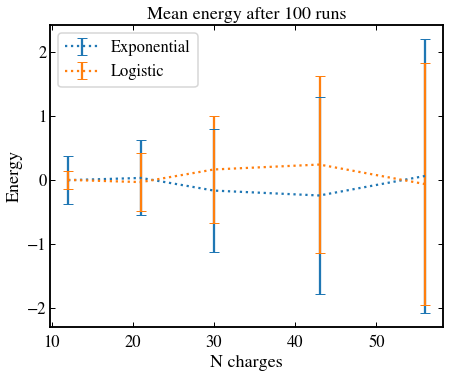

In [96]:

varias = np.zeros((len(n_charges_range), 2))
means = np.zeros((len(n_charges_range), 2))
stds = np.zeros((len(n_charges_range), 2))

for i, result_dict in enumerate([results_exp_test, results_log_test]):
    for j, n_charges in enumerate(n_charges_range):
        means[j][i] = result_dict[n_charges]['min_energy']
        stds[j][i] = result_dict[n_charges]['std_energy']
        varias[j][i] = result_dict[n_charges]['variability']


# plt.title('Variability')
# plt.plot(n_charges_range, varias[:, 0] - varias.mean(axis=1), label='Exponential')
# plt.plot(n_charges_range, varias[:, 1] - varias.mean(axis=1), label='Logistic')
# plt.legend()
# plt.show()

plt.figure(figsize=(8, 7))
plt.title('Mean energy after 100 runs')
plt.errorbar(n_charges_range, means[:, 0] - means.mean(axis=1), stds[:, 0], capsize=5, label='Exponential', ls=':')
plt.errorbar(n_charges_range, means[:, 1] - means.mean(axis=1), stds[:, 1], capsize=5, label='Logistic', ls=':')
plt.legend()
# plt.xlim(min(n_charges_range), max(n_charges_range))
plt.xlabel('N charges')
plt.ylabel('Energy')
plt.tight_layout()
plt.savefig('figures/test_temp_func.pdf')
plt.show()


In [68]:
# test with mc length 100

# simulation parameters
n_steps = 100

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

results_100_test = {}
for n_charges in n_charges_range:
    print(f'\nMc len 100 {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Mc_len_100_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_100_test[n_charges] = cc.get_results()


Mc len 100 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 100 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 100 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 100 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 100 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


In [69]:
# test with mc length 200

# simulation parameters
n_steps = 200

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

results_200_test = {}
for n_charges in n_charges_range:
    print(f'\nMc len {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Mc_len_200_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_200_test[n_charges] = cc.get_results()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 12


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished


In [70]:
# test with mc length 400

# simulation parameters
n_steps = 400

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

results_400_test = {}
for n_charges in n_charges_range:
    print(f'\nMc len 400 {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Mc_len_400_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_400_test[n_charges] = cc.get_results()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 400 12


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 400 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 400 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 400 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Mc len 400 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.3s finished


In [71]:
index = ['Variability', 'Minimum', 'Maximum', 'Mean', 'Standard deviation']

dct = {}
for n_charges in n_charges_range:
    dct[f'100 steps {n_charges}'] = results_100_test[n_charges].values()
    dct[f'200 steps {n_charges}'] = results_200_test[n_charges].values()
    dct[f'400 steps {n_charges}'] = results_400_test[n_charges].values()

df = pd.DataFrame(dct, index=index)
df

,100 steps 12,200 steps 12,400 steps 12,100 steps 21,200 steps 21,400 steps 21,100 steps 30,200 steps 30,400 steps 30,100 steps 43,200 steps 43,400 steps 43,100 steps 56,200 steps 56,400 steps 56
Variability,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Minimum,59.724657,59.577455,59.576281,216.886170,216.485423,216.202798,480.123355,479.177268,479.156979,1054.261012,1054.031768,1054.531524,1864.469158,1863.760272,1863.475276
Maximum,62.755247,60.722765,60.689174,220.890423,219.783320,219.696190,485.492343,482.038500,483.966115,1062.915161,1061.708254,1058.893242,1877.923031,1877.078405,1873.217345
Mean,60.560682,59.721408,59.668948,218.181558,217.026149,217.011709,482.019393,480.638464,480.413291,1058.008601,1056.561563,1056.344885,1869.485725,1867.532705,1867.311575
Standard deviation,0.576700,0.362461,0.301249,0.849404,0.649403,0.654814,1.260172,0.882465,0.946433,1.598470,1.437328,1.373973,2.406837,2.017991,2.073782


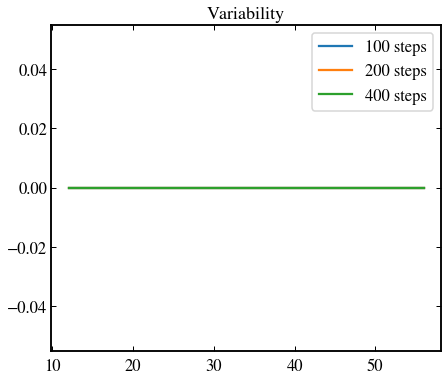

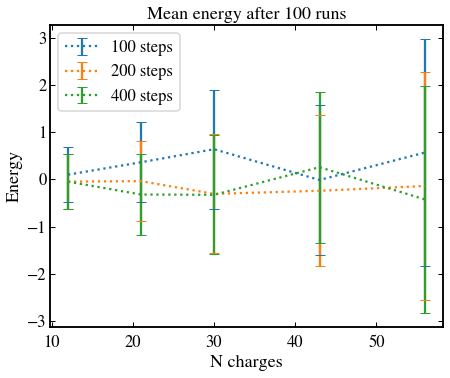

In [88]:

varias = np.zeros((len(n_charges_range), 3))
means = np.zeros((len(n_charges_range), 3))
stds = np.zeros((len(n_charges_range), 3))

for i, result_dict in enumerate([results_100_test, results_200_test, results_400_test]):
    for j, n_charges in enumerate(n_charges_range):
        means[j][i] = result_dict[n_charges]['min_energy']
        stds[j][i] = result_dict[n_charges]['std_energy']
        varias[j][i] = result_dict[n_charges]['variability']


# plt.title('Variability')
# plt.plot(n_charges_range, varias[:, 0] - varias.mean(axis=1), label='100 steps')
# plt.plot(n_charges_range, varias[:, 1] - varias.mean(axis=1), label='200 steps')
# plt.plot(n_charges_range, varias[:, 2] - varias.mean(axis=1), label='400 steps')
# plt.legend()
# plt.show()

plt.figure(figsize=(8, 7))
plt.title('Mean energy after 100 runs')
plt.errorbar(n_charges_range, means[:, 0] - means.mean(axis=1), stds[:, 0], capsize=5, label='100 steps', ls=':')
plt.errorbar(n_charges_range, means[:, 1] - means.mean(axis=1), stds[:, 0], capsize=5, label='200 steps', ls=':')
plt.errorbar(n_charges_range, means[:, 2] - means.mean(axis=1), stds[:, 0], capsize=5, label='400 steps', ls=':')
plt.legend()
plt.title('Mean energy after 100 runs')
# plt.xlim(min(n_charges_range), max(n_charges_range))
plt.xlabel('N charges')
plt.ylabel('Energy')
plt.tight_layout()
plt.savefig('figures/test_mc_length.pdf')
plt.show()

In [63]:
# test with stepsize to 0.1

# simulation parameters
n_steps = 400
stepsize_init = 0.05
stepsize_final = 0.025

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

results_var25_test = {}
for n_charges in n_charges_range:
    print(f'\nVar25 {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Var25_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_var25_test[n_charges] = cc.get_results()


Var25 12


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var25 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var25 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var25 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var25 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.5s finished


In [64]:
# test with stepsize to 0.1

# simulation parameters
stepsize_init = 0.05
stepsize_final = 0.01


results_var1_test = {}
for n_charges in n_charges_range:
    print(f'\nVar1 {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Var1_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_var1_test[n_charges] = cc.get_results()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var1 12


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var1 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var1 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var1 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var1 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.1s finished


In [65]:
# test with stepsize to 0.1

# simulation parameters
stepsize_init = 0.05
stepsize_final = 0.005

results_var05_test = {}
for n_charges in n_charges_range:
    print(f'\nVar05 {n_charges}')

    # initialize simulation
    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )

    # run the simulation
    # cc.run()
    cc.run_without_selection()

    # # produce image 
    # savepath = f'figures/Var05_{n_charges}.pdf'
    # cc.produce_figure(savepath=savepath)

    # get results
    results_var05_test[n_charges] = cc.get_results()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var05 12


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var05 21


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var05 30


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var05 43


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Var05 56


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.2s finished


In [66]:
index = ['Variability', 'Minimum', 'Maximum', 'Mean', 'Standard deviation']

dct = {}
for n_charges in n_charges_range:
    dct[f'No decrease, n={n_charges}'] = results_400_test[n_charges].values()
    dct[f'To 0.025, n={n_charges}'] = results_var25_test[n_charges].values()
    dct[f'To 0.01, n={n_charges}'] = results_var1_test[n_charges].values()
    dct[f'To 0.005, n={n_charges}'] = results_var05_test[n_charges].values()

df = pd.DataFrame(dct, index=index)
df

,"No decrease, n=12","To 0.025, n=12","To 0.01, n=12","To 0.005, n=12","No decrease, n=21","To 0.025, n=21","To 0.01, n=21","To 0.005, n=21","No decrease, n=30","To 0.025, n=30","To 0.01, n=30","To 0.005, n=30","No decrease, n=43","To 0.025, n=43","To 0.01, n=43","To 0.005, n=43","No decrease, n=56","To 0.025, n=56","To 0.01, n=56","To 0.005, n=56"
Variability,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Minimum,59.601113,59.592528,59.578252,59.576423,216.686412,216.455804,216.280527,216.205710,480.212289,479.930833,479.200667,479.197358,1056.570426,1054.941211,1054.212087,1053.704966,1868.567975,1865.541002,1864.416518,1863.691833
Maximum,60.785581,60.727419,60.697102,60.692308,218.327219,219.848956,217.823066,219.776590,485.089077,482.690165,484.183232,481.937676,1061.875927,1062.406240,1059.313462,1059.033835,1877.930911,1874.944719,1873.360839,1873.027358
Mean,59.767094,59.722207,59.684231,59.780016,217.269491,217.202812,217.124457,217.073478,481.640022,480.934674,480.617013,480.492002,1058.999082,1057.421189,1056.644081,1056.489109,1873.006598,1869.635320,1868.027770,1867.172674
Standard deviation,0.345393,0.329900,0.317144,0.426009,0.520838,0.644897,0.599037,0.659773,0.979956,0.794548,0.989260,0.817864,1.369352,1.365942,1.270022,1.368443,1.943816,2.156921,1.747372,1.985237


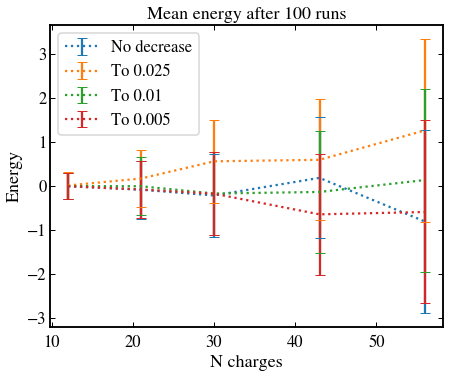

In [87]:

varias = np.zeros((len(n_charges_range), 4))
means = np.zeros((len(n_charges_range), 4))
stds = np.zeros((len(n_charges_range), 4))

for i, result_dict in enumerate([results_400_test, results_var25_test, results_var1_test, results_var05_test]):
    for j, n_charges in enumerate(n_charges_range):
        means[j][i] = result_dict[n_charges]['min_energy']
        stds[j][i] = result_dict[n_charges]['std_energy']
        varias[j][i] = result_dict[n_charges]['variability']



# plt.title('Variability')
# plt.plot(n_charges_range, varias[:, 0] - varias.mean(axis=1), label='No descrease')
# plt.plot(n_charges_range, varias[:, 1] - varias.mean(axis=1), label='To 0.025')
# plt.plot(n_charges_range, varias[:, 2] - varias.mean(axis=1), label='To 0.01')
# plt.plot(n_charges_range, varias[:, 3] - varias.mean(axis=1), label='To 0.005')
# plt.legend()
# plt.show()


plt.figure(figsize=(8, 7))
plt.errorbar(n_charges_range, means[:, 0] - means.mean(axis=1), stds[:, 0], capsize=5, label='No decrease', ls=':')
plt.errorbar(n_charges_range, means[:, 1] - means.mean(axis=1), stds[:, 0], capsize=5, label='To 0.025', ls=':')
plt.errorbar(n_charges_range, means[:, 2] - means.mean(axis=1), stds[:, 0], capsize=5, label='To 0.01', ls=':')
plt.errorbar(n_charges_range, means[:, 3] - means.mean(axis=1), stds[:, 0], capsize=5, label='To 0.005', ls=':')
plt.legend()
plt.title('Mean energy after 100 runs')
# plt.xlim(min(n_charges_range), max(n_charges_range))
plt.xlabel('N charges')
plt.ylabel('Energy')
plt.tight_layout()
plt.savefig('figures/test_decrease.pdf')
plt.show()

In [78]:
results_var25_test

{12: {'variability': 1,
  'min_energy': 59.59252800492122,
  'max_energy': 60.72741946993122,
  'mean_energy': 59.722207268895914,
  'std_energy': 0.32990005820914936},
 21: {'variability': 1,
  'min_energy': 216.45580426439255,
  'max_energy': 219.848955786966,
  'mean_energy': 217.20281206485822,
  'std_energy': 0.6448968056561353},
 30: {'variability': 1,
  'min_energy': 479.93083271423745,
  'max_energy': 482.69016533284594,
  'mean_energy': 480.9346737144112,
  'std_energy': 0.794547692713311},
 43: {'variability': 1,
  'min_energy': 1054.9412109647117,
  'max_energy': 1062.4062403260157,
  'mean_energy': 1057.4211892977212,
  'std_energy': 1.3659415041592244},
 56: {'variability': 1,
  'min_energy': 1865.5410016649787,
  'max_energy': 1874.944718525498,
  'mean_energy': 1869.635319984391,
  'std_energy': 2.1569214749192813}}

simulation: 100%|██████████| 1/1 [01:17<00:00, 77.78s/it]


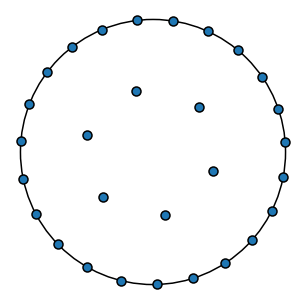

In [97]:

# simulation setings
n_attemps_per_run = 100
n_runs = 1
circle_radius = 1

# simulation parameters
n_steps = 400

stepsize_init = 0.05
stepsize_final = 0.005
random_influence = 1
force_influence = 1

# parameters for exponential cooling function
T_init = 1
constant = 0.965
temperature = cooling_exponential(n_steps, T_init, constant)

# n_charges_range = [55]
n_charges_range = [11, 12, 29, 30, 55, 56, 91, 92]


for n_charges in n_charges_range:


    cc = CircleCharges(
        n_charges, 
        n_attemps_per_run, 
        n_runs, 
        circle_radius, 
        n_steps, 
        stepsize_init, 
        stepsize_final, 
        random_influence, 
        force_influence, 
        temperature
    )
    cc.run()

    pos = cc.choose_best_run(cc.best_runs)[0]

    plt.figure(figsize=(6, 6))
    plt.box(False)
    plt.scatter(pos[:, 0], pos[:, 1], edgecolors='k', zorder=1)
    circle = plt.Circle((0, 0), 1, fill=False, zorder=-1)
    plt.gca().add_patch(circle)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f'figures/magic_numbers_{n_charges}.pdf')
    plt.show()

100%|██████████| 400/400 [00:03<00:00, 119.99it/s]


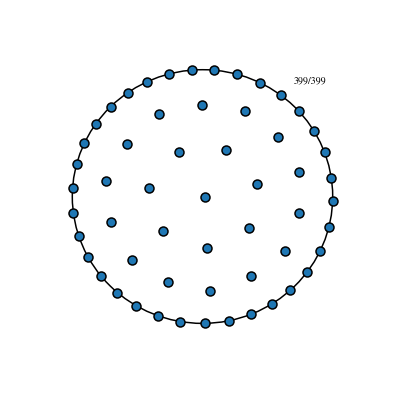

In [22]:
# n_charges = 56
# rs = RunSimulation(
#     n_charges,
#     circle_radius,
#     n_steps, 
#     stepsize_init,
#     stepsize_final,
#     random_influence, 
#     force_influence,
#     temperature
# )
# final_pos = rs.run()


# frames = 400
# sec = 15
# pos_animate = rs.pos_history[::n_steps//frames]
# fig, ax = plt.subplots(figsize=(7, 7))
# plt.box(False)
# plot = ax.scatter(pos_animate[0, :, 0], pos_animate[0, :, 1], edgecolors='k', zorder=1)
# text = ax.text(0.7, 0.9, '', fontsize=10)
# circle = plt.Circle((0, 0), 1, fill=False, zorder=-1)
# plt.gca().add_patch(circle)
# plt.xticks([])
# plt.yticks([])
# ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

# def anim_func(i):
#     plot.set_offsets(pos_animate[i])
#     text.set_text(f'{i}/{frames - 1}')
#     return plot

# animation = FuncAnimation(
#     fig, 
#     anim_func, 
#     frames=frames, 
#     interval=sec / frames * 1e3, 
#     save_count=frames
# )
# animation.save(f'56movie.mp4', dpi=500)